# Exploratory Mean-Variance Algorithm

In [ ]:
"""
Implementation of Exploratory Mean-Variance algorithm and MLE Mean-Variance algorithm
Primary Sources:
Wang, H., Zariphopoulou, T., & Zhou, X. Y. (2019). Exploration versus exploitation in reinforcement learning: a stochastic control approach. Available at SSRN 3316387.
Wang, H, & Zhou, XY. Continuous‐time mean–variance portfolio selection: A reinforcement learning framework. Mathematical Finance. (2020); 30: 1273– 1308. https://doi.org/10.1111/mafi.12281

Author: David Hyland
"""

In [ ]:
# Libraries
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas
from math import *

## Market Class

In [2]:
# Simulate the price of an asset.
class Asset:
    def __init__(self,name,mu,sigma,price,index):
        self.name = name # To easily distinguish between assets
        self.mu = mu # Drift
        self.sigma = sigma # Volatility
        self.initial_price = price # Initial price
        self.price = price # Current price
        self.index = index # Index number in the market
        self.mu_history = [mu]
        self.sigma_history = [sigma]
    
    # Reset the price of the asset
    def reset(self):
        self.price = self.initial_price

In [3]:
# Updates the price of all assets. Use if working with multiple assets.
class Market:
    def __init__(self,dt,r,stationary=True,inc_trajectories=None,price_trajectories=None):
        # Market parameters and data structures
        self.dt = dt
        self.r = r # Risk free rate
        self.stationary = stationary
        self.assets = []
        self.trajectories = None
        self.rhos = [] # Sharpe ratios
        # Parameters for non-stationary market
        self.gamma = 0
        self.delta = 0.0001
            
        # If pre-existing trajectories are given, no need to create assets
        if not(inc_trajectories is None or price_trajectories is None):
            self.inc_trajectories = inc_trajectories
            self.price_trajectories = price_trajectories
            self.use_data = True # Whether to use given trajectory data
        else:
            self.use_data = False
    
    """
    External use functions
    """
    
    def add_asset(self,name,mu,sigma,price):
        asset = Asset(name,mu,sigma,price,len(self.assets))
        self.assets.append(asset)
        self.rhos.append((mu-self.r)/sigma)
        
    # Returns two trajectories: prices and price increments
    def get_trajectory(self,n,index):
        if self.use_data:
            return self.get_stored_trajectory(index)
        else:
            return self.generate_trajectory(n)
    
    # Return increment of price of risky asset(s)
    def get_increment(self,index,position):
        if self.use_data:
            return self.get_stored_increment(index,position)
        else:
            return self.increment(0)
    
    # Return current price of risky asset(s)
    def get_price(self,index,position):
        if self.use_data:
            return self.get_stored_price(index,position)
        else:
            return self.assets[0].price
    
    """
    Internal (private) use functions
    """
    
    # Increment the price of an asset according to a certain price dynamics
    def increment(self,index):
        asset = self.assets[index]
        mu = asset.mu
        sigma = asset.sigma
        index = asset.index
        sharpe_ratio = (mu-self.r)/sigma
        price = asset.price
        
        dW = np.random.normal(0,1) * sqrt(self.dt) # Increment of brownian motion
    
        if(self.stationary):
            # Increment of brownian motion - Milstein Scheme
            price_increment = mu*self.dt + sigma*dW
            # Euler-Maruyama scheme - sigma * (sharpe_ratio*self.dt + dW)
            # Milstein scheme - (mu - 1/2*(sigma**2))*self.dt + (sigma + 1/2*(sigma**2)*dW)*dW 
        else:
            # Calculate price increment
            dW0 = np.random.normal(0,1) * sqrt(self.dt)
            price_increment = sigma*(sharpe_ratio*self.dt + dW0)
            
            # Update asset parameters and corresponding rho value
            sharpe_ratio += self.delta * self.dt
            self.rhos[index] = sharpe_ratio

            dW1 = self.gamma * dW0 + sqrt(1 - self.gamma**2) * dW
            asset.sigma += sigma*(self.delta * self.dt + sqrt(self.delta) * dW1)
            asset.mu = sharpe_ratio * sigma + self.r
            asset.mu_history.append(asset.mu)
            asset.sigma_history.append(asset.sigma)
        
        asset.price += price_increment*price
        return price_increment*price
    
    # Increment the prices of all risky assets
    def increment_all(self):
        price_incs = []
        if self.assets:
            for i in range(len(self.assets)):
                price_inc = self.increment(i)
                price_incs.append(price_inc)
        return price_incs
    
    # Generate a trajectory consisting of n increments of size dt
    def generate_trajectory(self,n):
        self.reset_all()
        price_trajectory = []
        price_increments = []
        for i in range(n):
            price_incs = self.increment_all()
            price_increments.append(price_incs[0])
            price = price_trajectory[i-1] + price_incs[0] if i>0 else 1
            price_trajectory.append(price)
        return price_trajectory,price_increments
    
    # Reset the price of the risky asset in the specified position
    def reset_asset(self,position):
        self.assets[position].reset()
        
    # Reset the prices of all risky assets
    def reset_all(self):
        if self.assets:
            for i in range(len(self.assets)):
                self.reset_asset(i)
    
    # Retrieve an entire trajectory from the market
    def get_stored_trajectory(self,index):
        if index >= 0 and self.price_trajectories and index < len(self.price_trajectories):
            return self.price_trajectories[index], self.inc_trajectories[index]
        else:
            return [],[]
    
    def get_stored_increment(self,index,position):
        if index >= 0 and self.inc_trajectories and index < len(self.inc_trajectories) and position < len(self.inc_trajectories[index]):
            return self.inc_trajectories[index][position]
        else:
            print(f"Could not get increment {index}, {position}")
            return 0
    
    def get_stored_price(self,index,position):
        if index >= 0 and self.price_trajectories and index < len(self.price_trajectories) and position < len(self.price_trajectories[index]):
            return self.price_trajectories[index][position]
        else:
            print("Could not get price")
            return 0

## MLE

In [4]:
class MLE_Environment:
    def __init__(self,T,M,market):
        # Extract information from the given market
        self.market = market
        
        # Environment parameters
        self.dt = market.dt
        self.T = T
        self.n = math.floor(self.T/self.dt) # Number of timesteps per trajectory
        self.M = M # Number of iterations
        self.epsilon = 0.0000001
    
    # Make sure log prices aren't below zero
    def check_log_values(self,values):
        safe_values = []
        for i in values:
            safe_values.append(i if i > 0 else self.epsilon)
        return safe_values
    
    # Run MLE MV Portfolio Optimization
    def MLE(self):
        # Problem parameters
        self.x0 = 1
        self.x = 1
        self.z = 1.4

        # Store data for plotting
        self.wealths = []
        self.param_history = []
        
        # Initialise MLE parameters
        mu_est = 0
        sigma_est = 0.15
        num_data = 100
        
        try:
            # Main loop
            for k in range(self.M):
                # Initialise sample wealth trajectory
                wealth_trajectory = [(0,self.x)]
                price_trajectory = [self.market.get_price(k,0)]
                log_returns = []
                
                # Generate wealth trajectory from number of given timepoints
                for i in range(self.n):
                    t = i*self.dt
                    
                    # increment price
                    price_increment = self.market.get_increment(k,i)
                    price_trajectory.append(self.market.get_price(k,i))
                    
                    # calculate and store log returns
                    if i > 0:
                        p1,p2 = self.check_log_values([price_trajectory[i],price_trajectory[i-1]]) 
                        log_returns.append(log(p1/p2))
                    
                    # update estimates
                    if(i > num_data):
                        start_j = i+1-num_data if (i >= num_data) else 1
                        stop_j = i+1 if (i > 0) else 2
                        var_est = 0
                        
                        if(i == num_data+1):
                            # First time calculating alpha 
                            alpha_est = 0 # alpha = mu - 0.5*sigma^2

                            # calculate estimate for alpha first
                            for j in range(start_j,stop_j):
#                                 p1,p2 = self.check_log_values([price_trajectory[j],price_trajectory[j-1]])
                                alpha_est += log_returns[j-1] #log(p1/p2)
                            alpha_est /= (stop_j-start_j)*self.dt
                        else:
                            # Only need to adjust one term
                            alpha_est *= (stop_j-start_j)*self.dt
#                             p1,p2,p3,p4 = self.check_log_values([price_trajectory[start_j],price_trajectory[start_j-1],price_trajectory[stop_j-1],price_trajectory[stop_j-2]])
                            alpha_est -= log_returns[start_j-1]#log(p1/p2)
                            alpha_est += log_returns[stop_j-2]#log(p3/p4)
                            alpha_est /= (stop_j-start_j)*self.dt
                        
                        # calculate estimate for sigma
                        for j in range(start_j,stop_j):
                            var_est += (log_returns[j-1] - alpha_est*self.dt)**2 #(log(price_trajectory[j]/price_trajectory[j-1]) - alpha_est*self.dt)**2
                        var_est /= (stop_j-start_j-1)*self.dt
                        sigma_est = sqrt(var_est)
                        mu_est = alpha_est + 0.5*var_est
                    
                    self.param_history.append([mu_est,sigma_est])
                    
                    # calculate allocation
                    sharpe_ratio_est = (mu_est - self.market.r)/sigma_est
                    w = (self.z*exp((sharpe_ratio_est**2)*self.T) - self.x0)/(exp((sharpe_ratio_est**2)*self.T) - 1)
                    allocation = -(sharpe_ratio_est/sigma_est)*(self.x-w)
                    
                    # increment wealth
                    dx = allocation * price_increment
                    self.x += dx
                    
                    # save wealth trajectory
                    wealth_trajectory.append((t,self.x))

                # Update parameters
                self.wealths.append(wealth_trajectory)
                
                # Reset wealth and asset price
                self.market.reset_all()

                self.x = self.x0
        except NameError as e:
            print(e)
        return self.wealths

## EMV agent

In [5]:
# Agent which updates parameters and policies
class EMV_Agent:
    def __init__(self,alpha,eta_t,eta_p,x0,z,explore,theta,phi,T,dt,leverage,sample=True):
        self.alpha = alpha # Learning rate for Lagrangian multiplier w
        self.eta_t = eta_t # Learning rate for theta vector
        self.eta_p = eta_p # Learning rate for phi vector
        self.x0 = x0 # Remember the initial wealth
        self.x = x0 # Current wealth
        self.z = z # Target terminal wealth
        self.explore = explore # Exploration rate/temperature parameter lambda
        self.lambda_0 = explore
        self.theta = theta # Vector of theta parameters
        self.phi = phi # Vector of phi parameters
        self.policy_mean = 0.1 # Mean of the current Gaussian policy
        self.policy_var = 1 # Variance of the current Gaussian policy
        self.T = T # Time horizon
        self.dt = dt # Increment size
        self.leverage = leverage
        self.sample = sample
#         self.w = 0.5
        self.w = (self.z*exp(self.theta[3]*self.T) - self.x0) / (exp(self.theta[3]*self.T) - 1) # Lagrange multiplier
        self.update_policy() # Initialise the policy
                                         
    # Sample allocation from the current policy
    def sample_policy(self,t):
        mean, var = self.get_policy_params(t)
        allocation = np.random.normal(mean,sqrt(var))
        # Apply leverage constraint if non-zero value provided
        if (self.leverage > 0 and abs(allocation) > self.leverage*abs(self.x)):
            return np.sign(allocation) * self.x
        return allocation
    
    # Sample allocation from the optimal policy
    def optimal_policy(self,rho,sigma,t):
        opt_mean, opt_var = self.get_optimal_params(rho,sigma,t)
        allocation = np.random.normal(opt_mean,sqrt(opt_var))
        return allocation

    # Calculate parameterised value function
    def value_function(self,t,x):
        return ((x-self.w)**2)*exp(-self.theta[3]*(self.T-t)) + self.theta[2]*(t**2) + self.theta[1]*t + self.theta[0]
                                         
    # Update the parameter values based on sampled market data
    # samples: list of tuples containing (t_i,x_i)
    def update_parameters(self,samples):
        # Use arrays to store the increments (theta_1, theta_2, phi_1, phi_2)
        dtheta = [0.0,0.0]
        dphi = [0.0,0.0]
                                         
        for i in range(len(samples) - 1):
            # Extract the relevant data from the samples array
            t_i = samples[i][0]
            t_i1 = samples[i+1][0]
            x_i = samples[i][1]
            x_i1 = samples[i+1][1]                      
            
            # Calculate quantities used in determining the gradient
            vdot = (self.value_function(t_i1,x_i1) - self.value_function(t_i,x_i))/self.dt
            entropy = self.phi[0] + self.phi[1]*(self.T-t_i)
            td_error = vdot - self.explore*entropy
            error_dt = td_error*self.dt
                                         
            # Add to the cumulative sum of errors
            dtheta[0] += error_dt
            dtheta[1] += td_error*(t_i1**2 - t_i**2)
            dphi[0] += error_dt
            dphi[1] += error_dt * (-((2/self.dt) * (((x_i1 - self.w)**2)*exp(-2*self.phi[1]*(self.T-t_i1))*(self.T - t_i1)\
                       - ((x_i-self.w)**2)*exp(-2*self.phi[1]*(self.T-t_i))*(self.T - t_i))) - self.explore*(self.T - t_i))
        
        # Multiply by the relevant scalars
        dphi[0] = -self.explore * dphi[0]

        # Update the parameters
        self.theta[1] -= self.eta_t*dtheta[0]
        self.theta[2] -= self.eta_t*dtheta[1]
        self.theta[0] = -self.theta[2]*(self.T**2) - self.theta[1]*self.T - (self.w - self.z)**2
        self.phi[0] -= self.eta_p*dphi[0]
#         if(self.phi[1] - self.eta_p*dphi[1] > 0):
#             self.phi[1] -= self.eta_p*dphi[1] # Because we assume > 0
        self.phi[1]  = max(self.phi[1]-self.eta_p*dphi[1],0)
        self.theta[3] = 2*self.phi[1]
        
    # Update the Gaussian policy based on the new parameter values.
    def update_policy(self):
        try:
            self.policy_mean = -sqrt((2*self.phi[1]) / (self.explore*pi)) * exp((2*self.phi[0]-1)/2)
            self.policy_var = (1/(2*pi)) * exp(2*self.phi[1]*(self.T) + 2 * self.phi[0] - 1)
        except OverflowError as e:
            print(f"Overflow. Phi: {self.phi[0]},{self.phi[1]}")
        
    # Get the current mean and variance of the policy based on the current wealth and time
    def get_policy_params(self,t):
        mean = self.policy_mean*(self.x-self.w)
        var = self.policy_var*exp(-2*self.phi[1]*t)
        return mean, var
    
    def get_optimal_params(self,rho,sigma,t):
        opt_w = (self.z*exp((rho**2)*self.T)-self.x0)/(exp((rho**2)*self.T)-1)
        opt_mean = (rho/sigma)*(self.x-opt_w)
        opt_var = (self.explore/(2*sigma**2))*exp((rho**2)*(self.T-t))
        return opt_mean, opt_var
                                         
    # Update the Lagrange multiplier using a stochastic approximation update
    # samples: a list of N different wealth trajectories (list of lists of (t_i,x_i))
    def update_w_approx(self,samples):
        sum_xT = 0 # Store the cumulative sum
        N = len(samples) # Number of trajectories
        
        # Sum the terminal wealth in all trajectories
        for i in range(N):
            sum_xT += samples[i][-1][1]
        
        # Update Lagarange multiplier
        self.w = self.w + self.alpha*(self.z - sum_xT/N)
    
    # Update the Lagrange multiplier directly using the form of the optimal Lagrange multiplier
    def update_w_direct(self):
        # Calculate optimal lagrange multiplier
        rho_squared = self.theta[3]
        self.w = (self.z*exp(rho_squared*self.T) - self.x0) / (exp(rho_squared*self.T) - 1)
    
    # Update the exploration parameter across episodes
    def update_explore(self,k,M):
        self.explore = self.lambda_0*(1-exp((200*(k-M))/(M)))
    
    # Reset wealth
    def reset(self):
        self.x = self.x0

## Environment for EMV agent

In [21]:
# Instantiate objects and co-ordinate the agent and market
class EMV_Environment:
    # Initialise environment with desired parameters
    def __init__(self,T,M,market=None):
        # Extract information from the given market
        self.market = market
        self.dt = market.dt
        if len(market.assets) > 0:
            self.risky_idx = market.assets[0].index
        
        # Environment parameters
        self.T = T
        self.n = math.floor(self.T/self.dt) # Number of timesteps per trajectory
        self.M = M # Number of iterations
        self.N = 50 # Number of trajectories per update of Lagrange multiplier
        self.delta = 0.0001
        self.gamma = 0
        
        # EMV parameters
        self.alpha = 0.07#0.05
        self.eta_t = 0.0005#0.0005
        self.eta_p = 0.0005#0.0005
        self.x0 = 1
        self.z = 1.4
        self.explore = 2
        self.theta = [-1,1,1,-1]
        self.phi = [1,1]

        # Create agent and initialise policy
        self.emv_agent = EMV_Agent(self.alpha,self.eta_t,self.eta_p,self.x0,self.z,\
                                   self.explore,self.theta,self.phi,self.T,self.dt,0)
        
        # Store data for plotting
        self.wealths = []
        self.phi_history = [self.emv_agent.phi]
        self.theta_history = [self.emv_agent.theta]
        self.policy_history = []
    
    """
    Run the EMV algorithm over the specified number of episodes
    optimal: whether or not the agent acts optimally or not
    new update: whether to use the original or new update scheme for the lagrange multiplier
    decay: whether or not to decay the exploration rate across training episodes
    """
    def EMV(self,optimal=False,new_update=False,decay=False):
        # Main loop
        for k in range(self.M):            
            # Generate wealth trajectory according to the current policy
            wealth_trajectory = self.generate_wealth_trajectory(optimal,k)
                
            # Store data and update parameters
            if(not optimal):
                # Update and store policy parameters
                self.emv_agent.update_parameters(wealth_trajectory)
                self.emv_agent.update_policy()
                self.phi_history.append([self.emv_agent.phi[0],self.emv_agent.phi[1]])
                self.theta_history.append([self.emv_agent.theta[0],self.emv_agent.theta[1],self.emv_agent.theta[2],self.emv_agent.theta[3]])
                
                # Logic for updating Lagrange Multiplier depending on which scheme is used
                if (k % self.N == 0 and not (k == 0)):
                    self.update_lagrange(new_update)
                    
                # Update exploration rate
                if(decay):
                    self.emv_agent.update_explore(k,self.M)

            self.wealths.append(wealth_trajectory)

            # Reset agent wealth for next training episode
            self.emv_agent.reset()
            self.market.reset_all()
        return self.wealths
    
    # Generate a single wealth trajectory according to the agent's current policy
    def generate_wealth_trajectory(self,optimal,k):
        # Initialise sample wealth trajectory
        wealth_trajectory = [(0,self.emv_agent.x)]
        
        if(optimal):
            mean,var = self.emv_agent.get_optimal_params(self.market.rhos[self.risky_idx],\
                                                         self.market.assets[self.risky_idx].sigma,0)
        else:
            mean,var = self.emv_agent.get_policy_params(0)
            
        self.policy_history.append([mean,var])
        
        # Generate wealth trajectory
        for i in range(self.n):
            t = i*self.dt

            # Sample allocation u from the current policy
            if(optimal):
                allocation = self.emv_agent.optimal_policy(self.market.rhos[self.risky_idx],\
                                                           self.market.assets[self.risky_idx].sigma,t)
            else:
                allocation = self.emv_agent.sample_policy(t)

            # Increment the wealth process
            price_inc = self.market.get_increment(k,i)
            dx = allocation * (price_inc - self.market.r*self.dt)
            self.emv_agent.x += dx
            wealth_trajectory.append((t,self.emv_agent.x))
            
        return wealth_trajectory
    
    # Update the agent's lagrange multiplier
    def update_lagrange(self, new_update):
        if(not new_update):
            self.emv_agent.update_w_approx(self.wealths[-self.N:])
        else:
            self.emv_agent.update_w_direct()

## Market Setup

In [8]:
# Create market environment
def create_market(dt,r,mu=0.3,sigma=0.1,price_trajectories=None,inc_trajectories=None,stationary=True):
    market = Market(dt,r,stationary,inc_trajectories,price_trajectories) # Create market
    if not(price_trajectories and inc_trajectories):
        market.add_asset("risky_1",mu,sigma,1.0)
    return market

# Pre generate a number of trajectories
def pre_generate_trajectories(num_steps,num_runs,market,mu=0.3,sigma=0.1):
    if(len(market.assets) == 0):
        market.add_asset("risky_1",mu,sigma,1.0)
    n = num_steps
    M = num_runs
    price_trajectories = []
    inc_trajectories = []
    for i in range(M):
        trajectory,increments = market.generate_trajectory(n)
        price_trajectories.append(trajectory)
        inc_trajectories.append(increments)
    market.price_trajectories = price_trajectories
    market.inc_trajectories = inc_trajectories
    market.use_data = True
    return price_trajectories,inc_trajectories,M,n
    
# Read price data from a list of csv file and break them up into trajectories
def read_csv_data(filenames,trajectory_size):
    price_incs = []
    prices = []
    inc_trajectories = []
    price_trajectories = []
    T = 1
    n = trajectory_size
    # Try to read each csv file and concatenate the data. Assumes all csv files have equal spacing
    for i in range(len(filenames)):
        try:
            # Read and parse the file
            data = pandas.read_csv(filenames[i])
            price_list_raw = data['price'].to_numpy().tolist()
            if i == 0:
                first_price = price_list_raw[0]
            price_list = [i/first_price for i in price_list_raw]
            for j in range(len(price_list)):
                # Add the price
                prices.append(price_list[j])
                # Beginning of a price list
                if(j == 0):
                    # No prices yet
                    if len(price_incs) == 0:
                        price_incs.append(0)
                    else:
                        price_incs.append(price_list[j]-last_price)
                    continue
                # Store price at end of price list for reference point
                if(j == len(price_list) - 1):
                    last_price = price_list[j]
                price_incs.append(price_list[j]-price_list[j-1])
        except FileNotFoundError as e:
            print(e)
    
    # Calculate the number of complete trajectories
    num_prices = len(price_incs)
    num_trajectories = math.floor(num_prices/trajectory_size)
    
    # Split the data up into trajectories
    for i in range(num_trajectories):
        inc_trajectories.append(price_incs[i*trajectory_size:(i+1)*trajectory_size])
        price_trajectories.append(prices[i*trajectory_size:(i+1)*trajectory_size])
    
    print(num_trajectories,trajectory_size,num_prices)
    dt = T/len(inc_trajectories[0])
    M = num_trajectories
    
    return price_trajectories,inc_trajectories,dt,M,n,T
    
"""
Data Loading/Generation
"""
# Use pre-existing data
def load_existing_data(n):
    r = 0.02
    n_ave = 2
    filenames = []
    num_files = 13
    for i in range(6,num_files):
        filenames.append(f'2018/crypto_prices_{i}.csv')
    for i in range(1,num_files):
        filenames.append(f'2019/crypto_prices_{i}.csv')
    price_trajectories,inc_trajectories,dt,M,n,T = read_csv_data(filenames,n)
    market = create_market(dt,r,price_trajectories,inc_trajectories)
    return market,dt,M,n,n_ave,r,T
    
def pre_generate_data(m=2000,mu=0.3,sigma=0.1,stationary=True):
    n = 252
    r = 0.02
    T = 1
    M = m
    n_ave = 50
    dt = T/n
    market = create_market(dt,r,mu,sigma,stationary=stationary)
    price_trajectories,inc_trajectories,M,n = pre_generate_trajectories(n,M,market)
    return market,dt,M,n,n_ave,r,T
    
def generate_on_demand(m=2000,mu=0.3,sigma=0.1):
    n = 252
    r = 0.02
    M = m
    T = 1
    n_ave = 50
    dt = T/n
    market = create_market(dt,r,mu,sigma)
    return market,dt,M,n,n_ave,r,T

## EMV User Functions

In [9]:
class EMV_Result():
    def __init__(self,emv_env,emv_wealths,emv_mean_terminal_wealths,emv_var_terminal_wealths,\
    emv_wealth_trajectory_vars,emv_terminal_wealths,emv_target_wealth):
        self.emv_env = emv_env
        self.emv_wealths = emv_wealths
        self.emv_mean_terminal_wealths = emv_mean_terminal_wealths
        self.emv_var_terminal_wealths = emv_var_terminal_wealths
        self.emv_wealth_trajectory_vars = emv_wealth_trajectory_vars
        self.emv_terminal_wealths = emv_terminal_wealths
        self.emv_target_wealth = emv_target_wealth

# Main program
def emv_run(T,M,n_ave,market=None):
    emv_env = EMV_Environment(T,M,market)
    emv_wealths = emv_env.EMV(False,False)
    emv_mean_terminal_wealths = []
    emv_var_terminal_wealths = []
    emv_wealth_trajectory_vars = []
    emv_terminal_wealths = []
    emv_target_wealth = [emv_env.z for i in range(len(emv_wealths)//n_ave)]
    for j in range(1,len(emv_wealths)+1):
        i = j-1
        emv_terminal_wealths.append(emv_wealths[i][-1][1])
        wealth_trajectory = [j[1] for j in emv_wealths[i]]
        emv_wealth_trajectory_vars.append(np.var(wealth_trajectory))
        if j % n_ave == 0:
            if(emv_terminal_wealths[j-n_ave:j]):
                mean_wealth = np.mean(emv_terminal_wealths[j-n_ave:j])
                var_wealth = np.var(emv_terminal_wealths[j-n_ave:j])
                emv_mean_terminal_wealths.append(mean_wealth)
                emv_var_terminal_wealths.append(var_wealth)
    return EMV_Result(emv_env,emv_wealths,emv_mean_terminal_wealths,emv_var_terminal_wealths,\
    emv_wealth_trajectory_vars,emv_terminal_wealths,emv_target_wealth)
    

# Run emv with initial parameters specified
def emv_run_custom(T,M,n_ave,phi,theta,market=None):
    emv_env = EMV_Environment(T,M,market)
    emv_env.emv_agent.phi = phi
    emv_env.emv_agent.theta = theta
    emv_wealths = emv_env.EMV(False,False)
    emv_mean_terminal_wealths = []
    emv_var_terminal_wealths = []
    emv_wealth_trajectory_vars = []
    emv_terminal_wealths = []
    emv_target_wealth = [emv_env.z for i in range(len(emv_wealths)//n_ave)]
    for j in range(1,len(emv_wealths)+1):
        i = j-1
        emv_terminal_wealths.append(emv_wealths[i][-1][1])
        wealth_trajectory = [j[1] for j in emv_wealths[i]]
        emv_wealth_trajectory_vars.append(np.var(wealth_trajectory))
        if j % n_ave == 0:
            if(emv_terminal_wealths[j-n_ave:j]):
                mean_wealth = np.mean(emv_terminal_wealths[j-n_ave:j])
                var_wealth = np.var(emv_terminal_wealths[j-n_ave:j])
                emv_mean_terminal_wealths.append(mean_wealth)
                emv_var_terminal_wealths.append(var_wealth)
    return EMV_Result(emv_env,emv_wealths,emv_mean_terminal_wealths,emv_var_terminal_wealths,\
    emv_wealth_trajectory_vars,emv_terminal_wealths,emv_target_wealth)
            
"""
Sample mean and variance of EMV terminal wealths            
"""
# Plotting mean
def emv_plot_mean_terminal_wealths(result,n):
    mean_terminal_wealths = result.emv_mean_terminal_wealths
    target_wealths = result.emv_target_wealth
    z = result.emv_env.z
    plt.plot(mean_terminal_wealths,label="EMV")
    plt.plot(target_wealths,label="Target z={}".format(z))
    plt.ylabel('Sample mean')
    plt.xlabel(f'Iteration (every {n})')
    plt.legend()
    plt.ylim(min(min(mean_terminal_wealths),0),max(max(mean_terminal_wealths),z+1))
    plt.show()

# Plotting var
def emv_plot_var_terminal_wealths(result,n):
    var_terminal_wealths = result.emv_var_terminal_wealths
    plt.plot(var_terminal_wealths,label="EMV")
    plt.ylabel('Sample Variance')
    plt.xlabel(f'Iteration (every {n})')
    plt.legend()
    plt.yscale('log')
    plt.show()

"""
Sample variance of wealth trajectories over time
"""
# Variance of individual trajectories
def emv_plot_wealth_sample_variance(result):
    wealth_trajectory_vars = result.emv_wealth_trajectory_vars
    plt.plot(wealth_trajectory_vars,label="EMV")
    plt.ylabel('Sample Variance')
    plt.xlabel('Iteration')
    plt.legend()
    plt.yscale('log')
    plt.show()
 

"""
Convergence of policy parameters to the true values
"""
def emv_calculate_optimal_policy_params(result,market):
    explore = result.emv_env.explore
    T = result.emv_env.T
    z = result.emv_env.z
    w = result.emv_env.emv_agent.w
    asset = market.assets[0]
    rho = market.rhos[0]
    phi1 = 0.5*log((pi*e*explore)/(asset.sigma**2))
    phi2 = 0.5*rho**2
    theta0 = (explore*(rho**2)*(T**2))/4 - \
             (explore/2)*((rho**2)*T) - log(asset.sigma**2/(pi*explore))*T \
             - (w-z)**2
    theta1 = (explore/2)*((rho**2)*T - log(asset.sigma**2/(pi*explore)))
    theta2 = (explore * (rho**2))/4
    theta3 = rho**2
    print("Phi: ",phi1,phi2)
    print("Theta: ",theta0,theta1,theta2,theta3)

# Time evolution of theta parameters
def emv_plot_theta_history(result,n):
    theta = result.emv_env.emv_agent.theta
    theta_history = result.emv_env.theta_history
    
    print("Final value:",theta)
    aves = []
    for i in range(4):
        aves.append(np.mean([j[i] for j in theta_history[-n:]]))
    print(f'Average of last {n} values: {aves}')
    plt.plot([i[0] for i in theta_history],label="theta_0")
    plt.plot([i[1] for i in theta_history],label="theta_1")
    plt.plot([i[2] for i in theta_history],label="theta_2")
    plt.plot([i[3] for i in theta_history],label="theta_3")
    plt.legend()
    plt.show() # Final values of theta and phi

# Time evolution of phi parameters
def emv_plot_phi_history(result,n):
    phi = result.emv_env.emv_agent.phi
    phi_history = result.emv_env.phi_history
    print("Final value:",phi)
    aves = []
    for i in range(2):
        aves.append(np.mean([j[i] for j in phi_history[-n:]]))
    print(f'Average of last {n} values: {aves}')
    plt.plot([i[0] for i in phi_history],label="phi_0")
    plt.plot([i[1] for i in phi_history],label="phi_1")
    plt.legend()
    plt.show()

# Plot time evolution of the mean and standard deviation of the control distribution
def emv_plot_policy_history(result):
    policy_history = result.emv_env.policy_history
    plt.subplot(2,1,1)
    plt.plot([i[0] for i in policy_history],label="mean")
    plt.subplot(2,1,2)
    plt.plot([i[1] for i in policy_history],label="stdv")
    plt.show()

"""
Time evolution of nonstationary asset mean and standard deviation
""" 
# Plot time evolution of the mean and standard deviation of the risky asset in nonstationary market
def emv_plot_nonstationary_asset_history(market):
    asset = market.assets[0]
    plt.subplot(2,1,1)
    plt.plot([i[0] for i in asset.mu_history],label="mu_risky")
    plt.subplot(2,1,2)
    plt.plot([i[1] for i in asset.sigma_history],label="sigma_risky")
    plt.show()

"""
EMV Sanity Check
"""
# Theoretical optimal control distribution at t=0
def emv_calculate_opt_params(result,market):
    emv_env = result.emv_env
    rho = market.rhos[0]
    sigma_risky = market.assets[0].sigma
    opt_lagrange = (emv_env.z*exp((rho**2)*emv_env.T)-emv_env.x0)/(exp(emv_env.T*(rho**2)) - 1)
    opt_mean = rho/sigma_risky*(1-opt_lagrange)
    opt_var = (emv_env.explore/(2*(sigma_risky**2)))*exp((rho**2)*(emv_env.T))
    print("Optimum:",opt_lagrange,opt_mean,opt_var)
    print("Agent:",emv_env.emv_agent.w,emv_env.policy_history[-1])
    
def emv_calculate_objective_function(result,market):
    emv_env = result.emv_env
    rho = market.rhos[0]
    opt_lagrange = (emv_env.z*exp((rho**2)*emv_env.T)-emv_env.x0)/(exp(emv_env.T*(rho**2)) - 1)
    mean_terminal_wealth = result.emv_mean_terminal_wealths[-1]
    objective_function = mean_terminal_wealth**2 - 2*opt_lagrange*mean_terminal_wealth - emv_env.z**2+ 2*opt_lagrange*emv_env.z
    return objective_function
    
# Plot of two sample trajectories from different stages in the training
def emv_compare_sample_trajectories(result,n1,n2):
    emv_wealths = result.emv_wealths
    plt.plot([i[1] for i in emv_wealths[n1]],label="early")
    plt.plot([i[1] for i in emv_wealths[n2]],label="later")
    plt.legend()
    plt.show()

## MLE User Functions

In [10]:
class MLE_Result():
    def __init__(self,mle_env,mle_wealths,mle_mean_terminal_wealths,mle_var_terminal_wealths,\
    mle_wealth_trajectory_vars,mle_terminal_wealths,mle_target_wealth):
        self.mle_env = mle_env
        self.mle_wealths = mle_wealths
        self.mle_mean_terminal_wealths = mle_mean_terminal_wealths
        self.mle_var_terminal_wealths = mle_var_terminal_wealths
        self.mle_wealth_trajectory_vars = mle_wealth_trajectory_vars
        self.mle_terminal_wealths = mle_terminal_wealths
        self.mle_target_wealth = mle_target_wealth

# Main program
def mle_run(T,M,n_ave,market=None):
    mle_env = MLE_Environment(T,M,market)
    mle_wealths = mle_env.MLE()
    mle_mean_terminal_wealths = []
    mle_var_terminal_wealths = []
    mle_wealth_trajectory_vars = []
    mle_terminal_wealths = []
    mle_target_wealth = [mle_env.z for i in range(len(mle_wealths)//n_ave)]
    for j in range(1,len(mle_wealths)+1):
        i = j-1
        mle_terminal_wealths.append(mle_wealths[i][-1][1])
        wealth_trajectory = [j[1] for j in mle_wealths[i]]
        mle_wealth_trajectory_vars.append(np.var(wealth_trajectory))
        if j % n_ave == 0:
            if(mle_terminal_wealths[j-n_ave:j]):
                mean_wealth = np.mean(mle_terminal_wealths[j-n_ave:j])
                var_wealth = np.var(mle_terminal_wealths[j-n_ave:j])
                mle_mean_terminal_wealths.append(mean_wealth)
                mle_var_terminal_wealths.append(var_wealth)
    return MLE_Result(mle_env,mle_wealths,mle_mean_terminal_wealths,mle_var_terminal_wealths,\
    mle_wealth_trajectory_vars,mle_terminal_wealths,mle_target_wealth)

"""
Plotting
"""
# Plotting mean
def mle_plot_mean_terminal_wealths(result,n):
    plt.plot(mle_mean_terminal_wealths,label="MLE")
    plt.plot(mle_target_wealth,label="Target z={}".format(mle_env.z))
    plt.ylabel('Sample mean')
    plt.xlabel(f'Iteration (every {n})')
    plt.legend()
    plt.ylim(min(min(mle_mean_terminal_wealths),0),max(max(mle_mean_terminal_wealths),mle_env.z+1))
    plt.show()
    
# Plotting var
def mle_plot_var_terminal_wealths(result,n):
    plt.plot(mle_var_terminal_wealths,label="MLE")
    plt.ylabel('Sample Variance')
    plt.xlabel(f'Iteration (every {n})')
    plt.legend()
    plt.yscale('log')
    plt.show()
    
# Variance of individual trajectories
def mle_plot_wealth_sample_variance(result):
    plt.plot(mle_wealth_trajectory_vars,label="MLE")
    plt.ylabel('Sample Variance')
    plt.xlabel('Iteration')
    plt.legend()
    plt.yscale('log')
    plt.show()
    
# Plot wealth trajectory at the beginning and end of training
def mle_compare_sample_trajectories(result,n1,n2):
    plt.plot([i[1] for i in mle_wealths[n1]],label="early")
    plt.plot([i[1] for i in mle_wealths[n2]],label="later")
    plt.legend()
    plt.show()
    
"""
Sanity Checks
"""
# Calculate averaged parameter values over every n iterations (100)
def mle_calclate_average_param_vals(result,n):
    mean_averages = []
    sigma_averages = []
    for i in range(0,len(mle_env.param_history),n):
        if i > 0:
            means = [j[0] for j in mle_env.param_history[i-n:i]]
            sigmas = [j[1] for j in mle_env.param_history[i-n:i]]
            mean_averages.append(np.mean(means))
            sigma_averages.append(np.mean(sigmas))
    return mean_averages,sigma_averages
            
# Plot the time evolution of the parameter values averaged over 100 iterations
def mle_plot_parameter_values(mean_averages,sigma_averages):
    plt.plot(mean_averages,label="mean")
    plt.plot(sigma_averages,label="sigma")
    plt.legend()
    plt.show()
    
# Histogram of average estimated mean values
def mle_plot_histogram_mean(mean_averages,binsize):
    plt.hist(mean_averages,bins=binsize)
    plt.show()
    
# Histogram of average estimated sigma values
def mle_plot_histogram_sigma(sigma_averages,binsize):
    plt.hist(sigma_averages,bins=binsize)
    plt.show()

## EMV Experiments

### Hyper-parameter Explorer

In [26]:
class Parameter_Explorer():
    def __init__(self,decay=False):
        # Dictionary of parameter
        self.param_dict = {"lambda":0,"alpha":1,"eta_t":2,"eta_p":3,"delta":4,"gamma":5}
        # Method to call depending on argument passed
        self.method_dict = {"const_linear":self.const_linear,"const_exponential":self.const_exponential}
        # Valid metrics to use
        self.valid_metrics = {0:"mean",1:"var",2:"mean distance"}
        # X axis labels
        self.xlabels = {"mean":"Mean time to convergence", "var":"Average variance of terminal wealths","mean distance":"Mean absolute deviation from target"}
        # Variable to store wealth trajectories
        self.emv_wealths = []
        # Data for plotting
        self.performance_data = []
        # Whether to decay exploration rate
        self.decay=decay
        
    
    """
    Evaluate the performance of a parameter scheme
    num_exp: number of expeirments to do
    method: updating scheme for the parameter (str)
    parameter: name parameter to be updated (str)
    method_args: list containing all the arguments to be passed to the method (list). first argument is always the initial value of the parameter_explorer
    """
    def evaluate_performance(self,num_exp,method,parameter,method_args,metric,n,epsilon,target,m=2000):
        # Set up environment
        market,dt,M,n,n_ave,r,T = pre_generate_data(m)
        emv_env = EMV_Environment(T,M,market)
        param_value = method_args[0]
        self.parameter = parameter
        
        # Experimental loop
        for i in range(num_exp):
#             market,dt,M,n,n_ave,r,T = pre_generate_data()
            
            # Run EMV
            try:
                self.emv_wealths = emv_env.EMV(False,False,decay=self.decay)
            except OverflowError as e:
                print(e)
                return
            
            # Generate new environment
            emv_env = EMV_Environment(T,M,market)
            
            # Get new parameter value
            new_value = self.method_dict[method](method_args)
            
            # Set parameter value
            self.set_val(emv_env,parameter,new_value)

            # Calculate and store performance metrics
            conv_time = self.time_to_convergence(metric,n,epsilon,target)
            conv_variance = self.variance_in_range(conv_time - n,conv_time)
            ave_terminal_dist = self.ave_distance_to_target(conv_time - n,conv_time,target)
            self.performance_data.append([new_value,conv_time,conv_variance,ave_terminal_dist])
        
    """
    Update functions
    """
    # Set the value of the desired parameter
    def set_val(self,emv_env,parameter,value):
        if parameter not in self.param_dict.keys():
            print("Parameter name not found.")
            return
        # Update the value
        v = self.param_dict[parameter]
        if v == 0:
            emv_env.explore = value
            emv_env.emv_agent.explore = value
        elif v == 1:
            emv_env.alpha = value
            emv_env.emv_agent.alpha = value
        elif v == 2:
            emv_env.eta_t = value
            emv_env.emv_agent.eta_t = value
        elif v == 3:
            emv_env.eta_p = value
            emv_env.emv_agent.eta_p = value
        elif v == 4:
            emv_env.delta = value
            emv_env.market.delta = value
        elif v == 5:
            emv_env.gamma = value
            emv_env.market.gamma = value
    
    # Holding lambda constant across experiments and incrementing linearly 
    def const_linear(self,method_args):
        if not len(method_args) == 2:
            print("Please pass in list with 2 arguments.")
            return -1
        else:
            method_args[0] = method_args[0] + method_args[1]
            return method_args[0]
    
    def const_exponential(self,method_args):
        if not len(method_args) == 2:
            print("Please pass in list with 2 arguments.")
            return -1
        else:
            method_args[0] = method_args[0] * method_args[1]
            return method_args[0]
    
    """
    Performance Metrics
    """
    # How long it takes for average performance across n consecutive episodes to be within epsilon of the target value
    def time_to_convergence(self,metric,n,epsilon,target):
        num_trajectories = len(self.emv_wealths)
        if num_trajectories >= n and metric in self.valid_metrics.values():
            num_iterations = num_trajectories - n + 1
            for i in range(num_iterations):
                terminal_wealths = []
                
                # Get data in the desired range
                for j in range(i,i+n):
                    terminal_wealths.append(self.emv_wealths[j][-1][1])
                    
                # Calculate metric on terminal wealth data
                if(metric == 'mean'):
                    metric_value = np.mean(terminal_wealths)
                elif(metric == 'var'):
                    metric_value = np.var(terminal_wealths)
                else:
                    print("Invalid metric")
                    return -2
            
                # See if metric is within epsilon of target
                if(abs(metric_value - target) <= epsilon):
                    return i+n
            
            # If performance doesn't converge, return the number of trajectories
            return num_trajectories
        else:
            return -1
    
    # Calculate the sample variance of terminal wealths between two indices
    def variance_in_range(self,start_idx,stop_idx):
        if(start_idx >= 0 and stop_idx <= len(self.emv_wealths) and stop_idx-start_idx > 1):
            terminal_wealths = []
            for i in range(start_idx,stop_idx):
                terminal_wealths.append(self.emv_wealths[i][-1][1])
            return np.var(terminal_wealths)
        else:
            return -1
    
    def ave_distance_to_target(self,start_idx,stop_idx,target):
        if(start_idx >= 0 and stop_idx <= len(self.emv_wealths) and stop_idx-start_idx > 1):
            terminal_dist = []
            for i in range(start_idx,stop_idx):
                terminal_dist.append(self.emv_wealths[i][-1][1] - target)
            return np.mean(terminal_dist)
        else:
            return -1
    
"""
Plotting and Results Analysis
"""
# Plot a given metric as a function of the parameter value
def plot_performance(explorer,index,logx=False,logy=False,ylower=-1):
    x_vals = [i[0] for i in explorer.performance_data]
    y_vals = [i[index+1] for i in explorer.performance_data]
    plt.figure(figsize=(20,10))
    plt.plot(x_vals,y_vals,color='purple',linewidth=1.5,label="EMV")
    if(logx):
        plt.xscale('log')
    if(logy):
        plt.yscale('log')
    # Specify y range
    if(not ylower == -1):
        plt.ylim(ylower,2*max(y_vals))
    plt.rc('xtick', labelsize=15)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=15)    # fontsize of the tick labels
    plt.rc('legend', fontsize=15)    # legend fontsize
    plt.ylabel(explorer.xlabels[explorer.valid_metrics[index]],fontsize=20)
    plt.xlabel(explorer.parameter,fontsize=20)
    plt.legend()
    plt.show()

### MLE pre-computing

In [12]:
# Make sure log prices aren't below zero
def check_log_values(values,epsilon):
    safe_values = []
    for i in values:
        if i < 0:
            print("Ouch")
        safe_values.append(i if i > 0 else epsilon)
    return safe_values

# Calculate MLE for mu and sigma, generate_trajectories based on the computed values
def MLE_compute(M,dt,market):
    mu_estimates = []
    sigma_estimates = []
    log_returns = []

    alpha_est = 0 # alpha = mu - 0.5*sigma^2
    var_est = 0
    last_val = 0
    num_points = 0
    
    for k in range(M):
        # Initialise price trajectory
        price_trajectory, inc_trajectory = market.get_trajectory(0,k)
        num_data = len(price_trajectory)

        # calculate estimate for alpha first
        for i in range(1,num_data):
            p1,p2 = check_log_values([price_trajectory[i],price_trajectory[i-1]],0.0001)
            log_return = log(p1/p2)
            alpha_est += log_return
            # Store data
            log_returns.append(log_return)
            num_points+=1
    total_data = len(log_returns)
    alpha_est = alpha_est/((total_data+1)*dt)
    
    # calculate estimate for sigma
    for i in range(total_data):
        var_est += (log_returns[i] - alpha_est*dt)**2
    var_est = var_est /((total_data+1)*dt)
    sigma_est = sqrt(var_est)
    mu_est = alpha_est + 0.5*var_est
    print(num_points,total_data)
    return mu_est,sigma_est

def pre_train_mle():
    global M, dt, market
    load_existing_data(250)
    mu_est,sigma_est = MLE_compute(M,dt,market)
    print(mu_est,sigma_est)
    r = 0.02
    M = 10000
    T = 1
    n_ave = 50
    dt = T/n
    market = create_market(dt,r)
    price_trajectories,inc_trajectories,M,n = pre_generate_trajectories(n,M,market,mu=mu_est,sigma=sigma_est)
    emv_run(T,M,n_ave,market)
    phi = [i for i in emv_env.emv_agent.phi]
    theta = [i for i in emv_env.emv_agent.theta]
    load_existing_data(250)
    print(M,len(market.price_trajectories))
    emv_run_custom(T,M,2,phi,theta,market)
    emv_plot_mean_terminal_wealths(2)

## Honours Plots

In [13]:
"""
Plots comparing EMV and MLE
"""
def emv_mle_comparison(stationary=True):
    # Set up
    market,dt,M,n,n_ave,r,T = pre_generate_data(m=15000,stationary=stationary)
    # Run algorithms
    emv_result = emv_run(T,M,n_ave,market)
    mle_result = mle_run(T,M,n_ave,market)
    return emv_result,mle_result,n_ave

def emv_mle_plot_mean(emv_result,mle_result,n_ave):
    # Extract relevant data
    target_wealth = emv_result.emv_target_wealth
    emv_mean_terminal_wealths = emv_result.emv_mean_terminal_wealths
    mle_mean_terminal_wealths = mle_result.mle_mean_terminal_wealths
    z = emv_result.emv_env.z
    
    # Plotting mean terminal wealths
    plt.figure(figsize=(20,10))
    plt.plot(target_wealth,linestyle="--",linewidth=1.5,color='blue',label=f"Target z={z}")
    plt.plot(mle_mean_terminal_wealths,linewidth=1,color='pink',label="MLE")
    plt.plot(emv_mean_terminal_wealths,color='purple',label="EMV")
    plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
    plt.rc('legend', fontsize=25)    # legend fontsize
    plt.ylabel('Sample mean', fontsize=25)
    plt.xlabel(f'Iteration (every {n_ave})', fontsize=25)
    plt.legend(loc='upper right')
#     plt.ylim(min(min(min(mle_mean_terminal_wealths),min(emv_mean_terminal_wealths)),0),max(max(max(mle_mean_terminal_wealths),max(emv_mean_terminal_wealths)),z+1))
    plt.ylim(-1,3)
    plt.show()
    
def emv_mle_plot_var(emv_result,mle_result,n_ave):
    # Extract relevant data
    emv_var_terminal_wealths = emv_result.emv_var_terminal_wealths
    mle_var_terminal_wealths = mle_result.mle_var_terminal_wealths
    
    # Plotting mean terminal wealths
    plt.figure(figsize=(20,10))
    plt.plot(mle_var_terminal_wealths,linewidth=2,color='pink',label="MLE")
    plt.plot(emv_var_terminal_wealths,color='purple',label="EMV")
    plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
    plt.rc('legend', fontsize=25)    # legend fontsize
    plt.ylabel('Sample variance', fontsize=25)
    plt.xlabel(f'Iteration (every {n_ave})', fontsize=25)
    plt.legend(loc='upper right')
    plt.yscale('log')
    plt.show()

In [14]:
"""
Comparison of EMV and MLE in stationary market scenario
"""
emv_result,mle_result,n_ave = emv_mle_comparison(True)

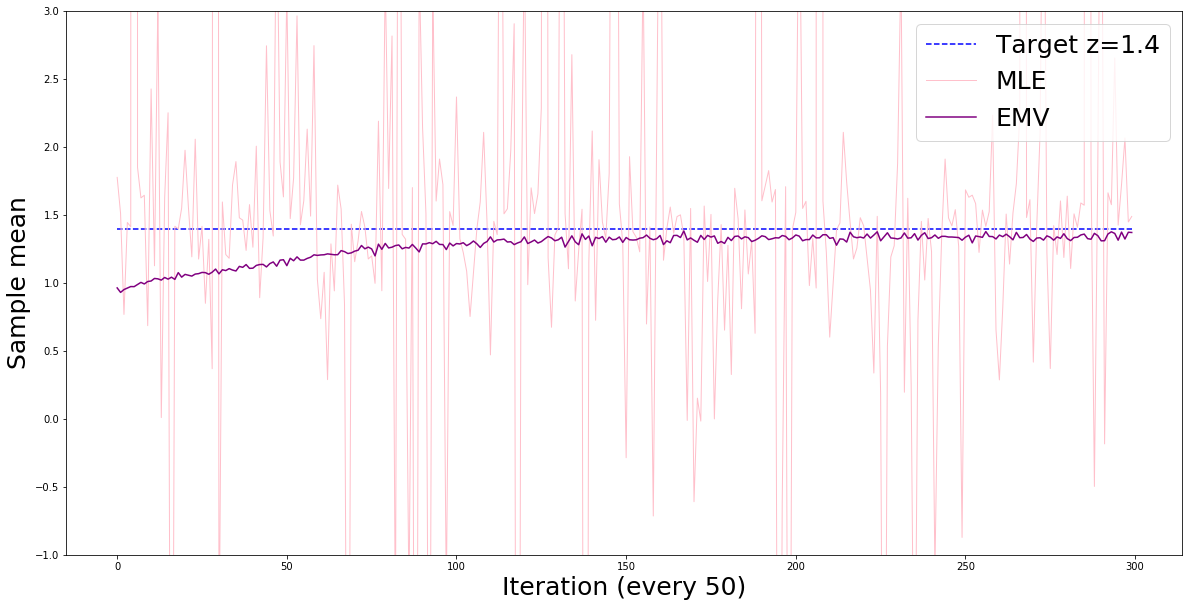

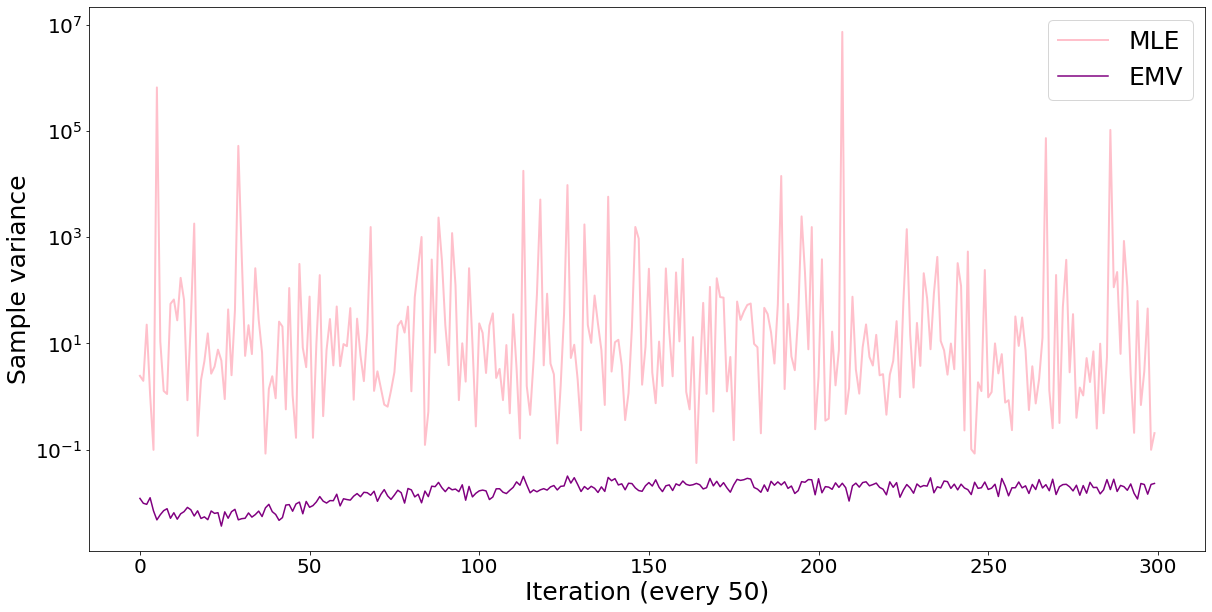

In [15]:
emv_mle_plot_mean(emv_result,mle_result,n_ave)
emv_mle_plot_var(emv_result,mle_result,n_ave)

In [17]:
"""
Comparison of EMV and MLE in non-stationary market scenario
"""
emv_result2,mle_result2,n_ave = emv_mle_comparison(False)

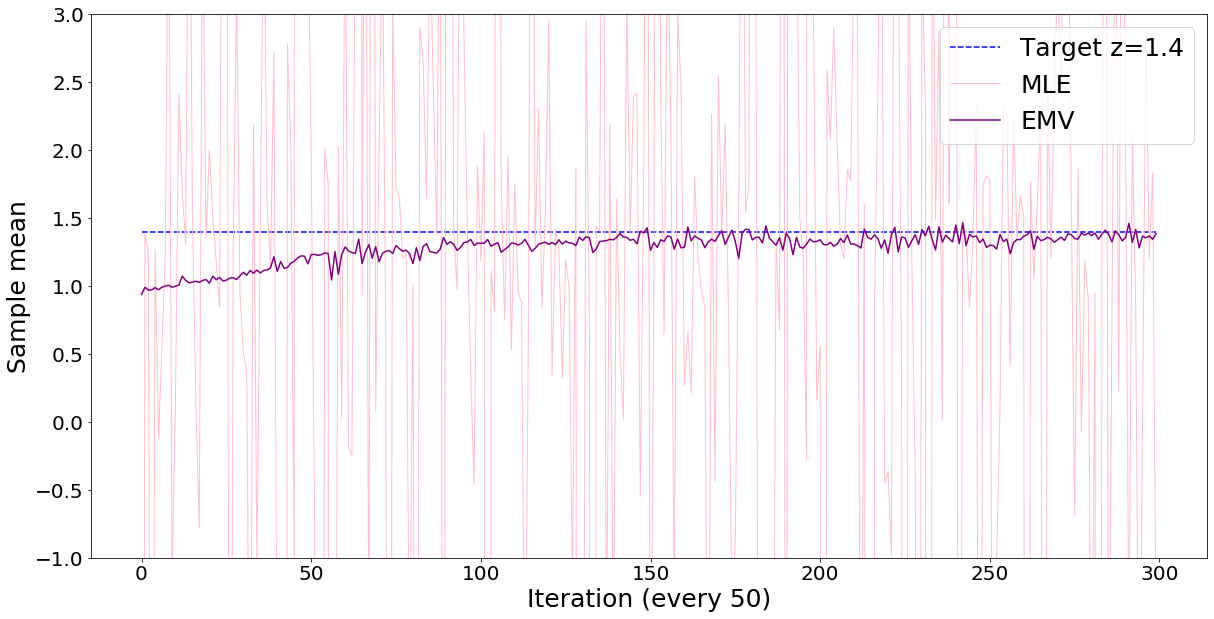

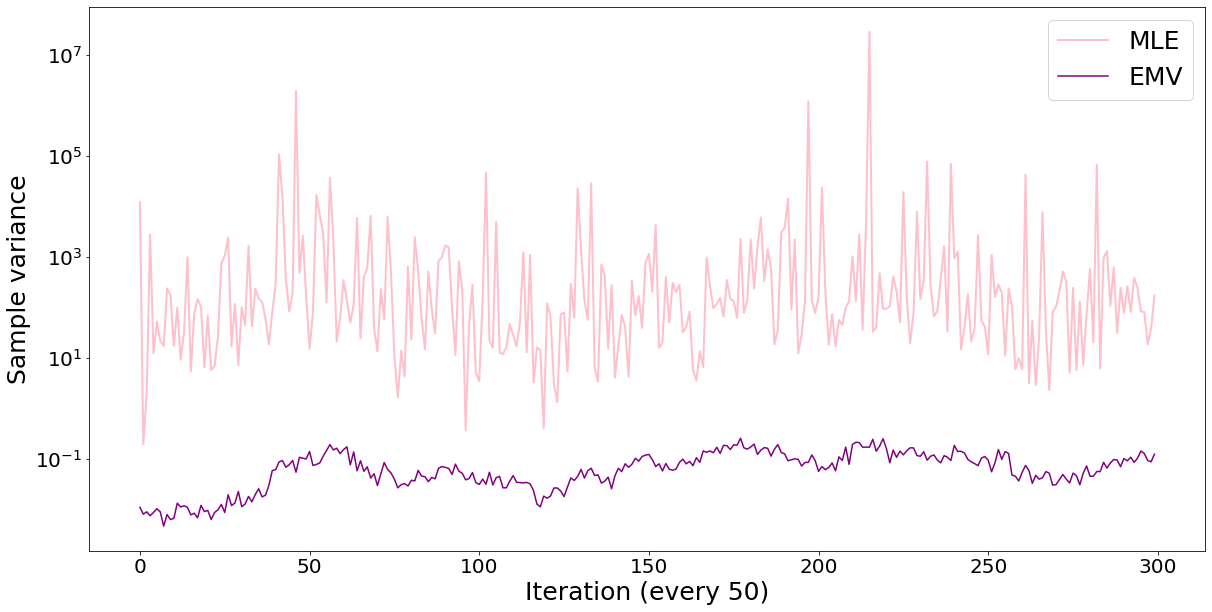

In [18]:
emv_mle_plot_mean(emv_result2,mle_result2,n_ave)
emv_mle_plot_var(emv_result2,mle_result2,n_ave)

In [28]:
"""
Plots of EMV performance as we vary lambda
"""
# Hyperparameter exploration linear
lambda_explorer = Parameter_Explorer(decay=False)
lambda_explorer.evaluate_performance(num_exp=25,method="const_linear",parameter="lambda",method_args=[1,1],metric='mean',n=100,epsilon=0.05,target=1.4,m=20000)

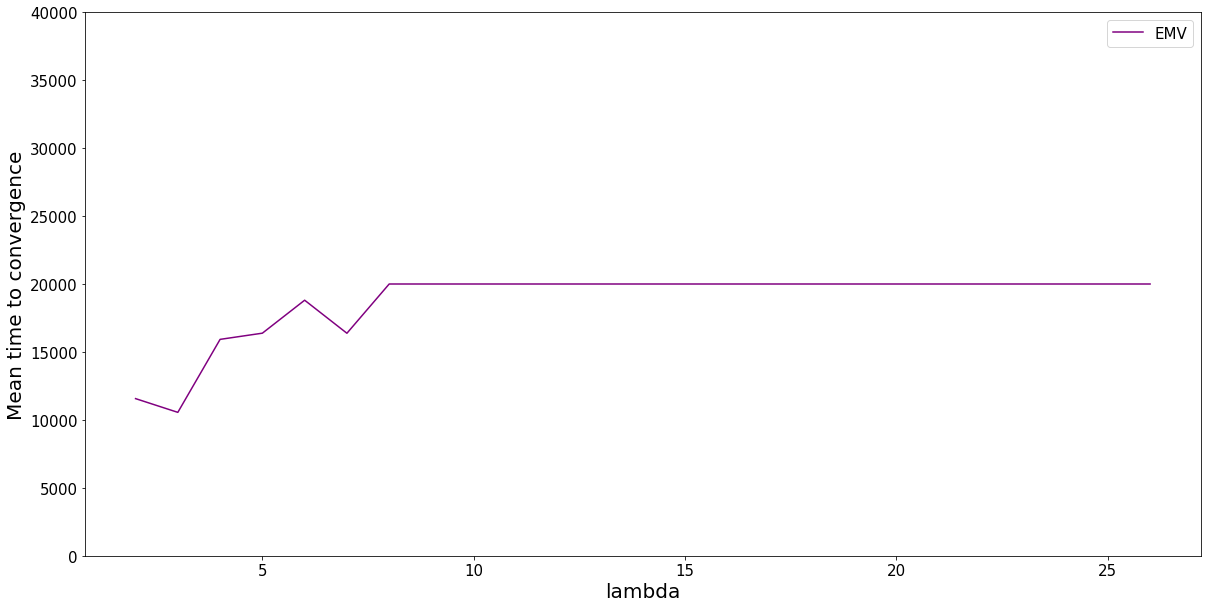

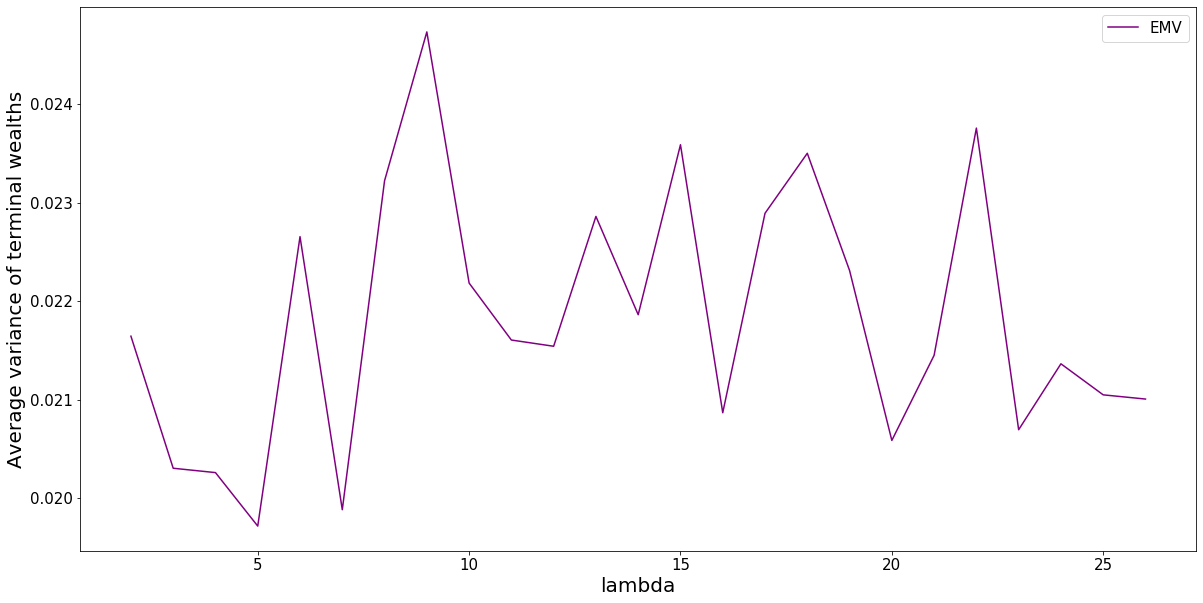

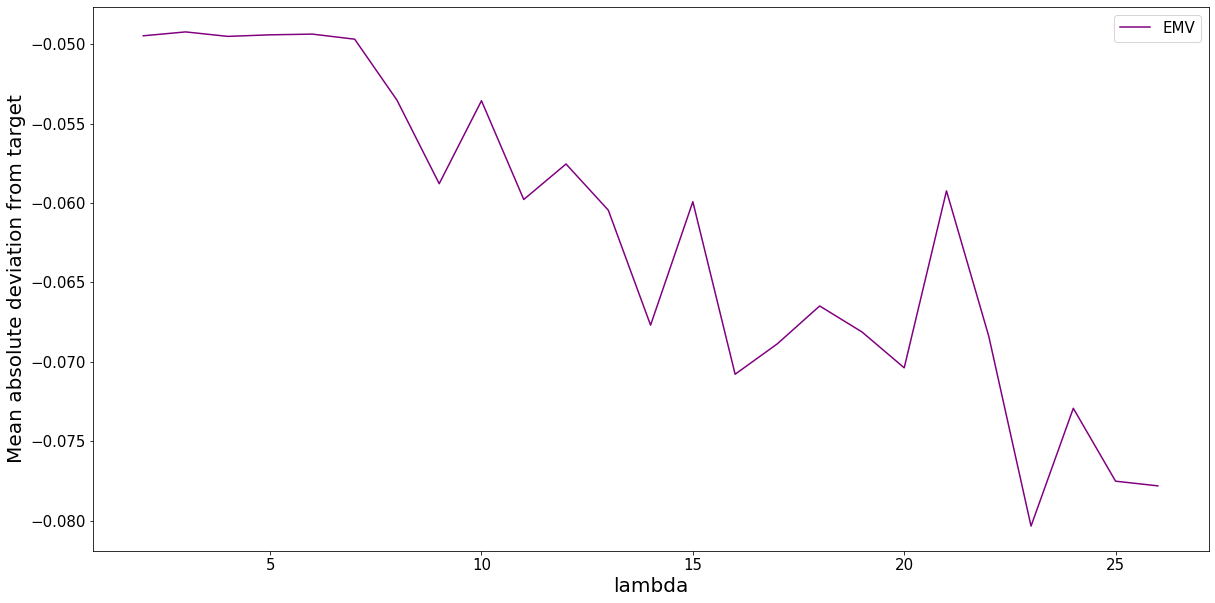

In [29]:
plot_performance(lambda_explorer,0,ylower=0)
plot_performance(lambda_explorer,1)
plot_performance(lambda_explorer,2)

In [ ]:
"""
Pure performance comparison without convergence
"""
lambda_explorer2 = Parameter_Explorer()
lambda_explorer2.evaluate_performance(num_exp=50,method="const_linear",parameter="lambda",method_args=[1,0.5],metric='mean',n=100,epsilon=0,target=1.4,m=15000)

In [ ]:
plot_performance(lambda_explorer2,0)
plot_performance(lambda_explorer2,1)
plot_performance(lambda_explorer2,2)

In [ ]:
"""
Effect of initialisation
"""

## Testing

In [ ]:
# Simulated data
pre_generate_data()
market.assets[0].mu

In [ ]:
# Existing data
load_existing_data(100)

In [ ]:
# MLE pre-training method
pre_train_mle()

In [ ]:
# Run EMV once
emv_run(T,M,n_ave,market)

In [ ]:
# Plot results from one run
emv_plot_mean_terminal_wealths(50)

In [ ]:
# Performance on historical data
load_existing_data()
emv_run(T,M,n_ave,market)

In [ ]:
# Plot performance on real stock data
emv_plot_mean_terminal_wealths(n_ave)
emv_plot_var_terminal_wealths(n_ave)

In [ ]:
# Hyperparameter exploration exponential
lambda_explorer = Parameter_Explorer()
lambda_explorer.evaluate_performance(num_exp=10,method="const_exponential",parameter="lambda",method_args=[0.01,2],metric='mean',n=100,epsilon=0.05,target=1.4,m=1000)
lambda_explorer.plot_performance(0)

In [ ]:
# MLE Testing
market,dt,M,n,n_ave,r,T = pre_generate_data(m=10000,stationary=True)
mle_result_3 = mle_run(T,M,n_ave,market)

In [ ]:
# Should be normally distributed around true mu and sigma
mean_averages,sigma_averages = mle_calclate_average_param_vals(mle_result_3,100)
mle_plot_parameter_values(mean_averages,sigma_averages)
mle_plot_histogram_mean(mean_averages,40)
mle_plot_histogram_sigma(sigma_averages,40)

In [ ]:
# Should be close to true mu and sigma
print(np.mean(mean_averages), np.mean(sigma_averages))